# Prédiction du type d’entraînement (`Workout_Type`)


L’objectif de cette étude est de prédire le type d’entraînement d’un individu (Cardio, HIIT, Strength ou Yoga) à partir de plusieurs caractéristiques physiques et sportives.

Nous allons :
- charger et préparer la base de données,
- encoder la variable cible `Workout_Type`,
- sélectionner des variables pertinentes pour la prédiction,
- tester plusieurs modèles (KNN, arbre de décision, régression logistique, RandomForest, SVM),
- comparer leurs performances,
- choisir le meilleur modèle,
- et interpréter les résultats.

Pour cela, nous allons utiliser plusieurs caractéristiques comme :

- la durée de la séance,
- les calories brûlées,
- le niveau d’expérience,
- le poids de l’individu.

L’objectif est :

- d'entraîner plusieurs modèles (KNN, arbre de décision, régression logistique),
- de comparer leurs performances,
- de choisir le meilleur,
- et de construire une fonction permettant de tester manuellement un profil.


In [312]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid")
np.random.seed(42)


## Chargement et préparation des données

On importe la base, on encode Workout_Type, Experience_Level et is_Healthy en valeurs numériques et on prépare les colonnes utiles à l’étude.
Cela permet de bien comprendre les résultats et les matrices de confusion obtenues plus tard.


In [400]:
df = pd.read_csv("Newdata.csv")

mapping_workout = {"Cardio": 1, "HIIT": 2, "Strength": 3, "Yoga": 4}
df["Workout_Type_encode"] = df["Workout_Type"].map(mapping_workout)

df["Experience_Level"] = df["Experience_Level"].round().astype(int)
df['is_healthy_encode'] = df['is_healthy'].round().astype(int)
print("Aperçu des données :")
display(df.head())

counts_true = df["Workout_Type"].value_counts().sort_index()

counts_encoded = df["Workout_Type_encode"].value_counts().sort_index()

mapping_table = pd.DataFrame({
    "Workout_Type": counts_true.index,
    "Code": [mapping_workout[val] for val in counts_true.index],
    "Effectif": counts_true.values
})

print("\nRéférentiel Workout_Type (texte ↔ code) :")
display(mapping_table)


Aperçu des données :


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Workout_Type_encode,is_healthy_encode
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,3,0
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,2,0
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1,0
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,2,0
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,3,0



Référentiel Workout_Type (texte ↔ code) :


,Workout_Type,Code,Effectif
0,Cardio,1,4923
1,HIIT,2,4974
2,Strength,3,5071
3,Yoga,4,5032


## Distribution de la variable cible Workout_Type_encode


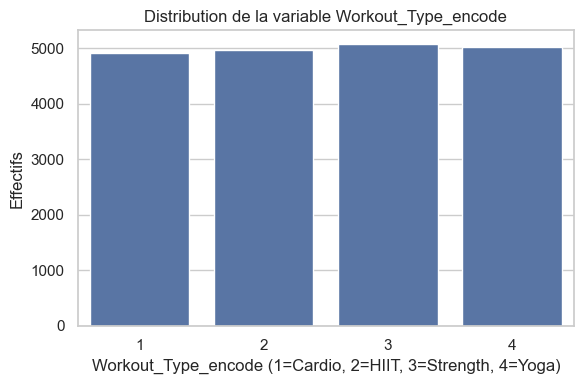

In [401]:
plt.figure(figsize=(6,4))
sns.countplot(x="Workout_Type_encode", data=df)
plt.title("Distribution de la variable Workout_Type_encode")
plt.xlabel("Workout_Type_encode (1=Cardio, 2=HIIT, 3=Strength, 4=Yoga)")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Sélection des variables explicatives

On utilise les variables liées à l’entraînement : durée de séance, calories brûlées, niveau d’expérience et poids.


Index(['Calories_Burned', 'cal_balance', 'pct_HRR', 'Avg_BPM',
       'cholesterol_mg', 'pct_maxHR', 'Resting_BPM', 'pct_carbs',
       'Workout_Frequency (days/week)', 'Session_Duration (hours)'],
      dtype='object')


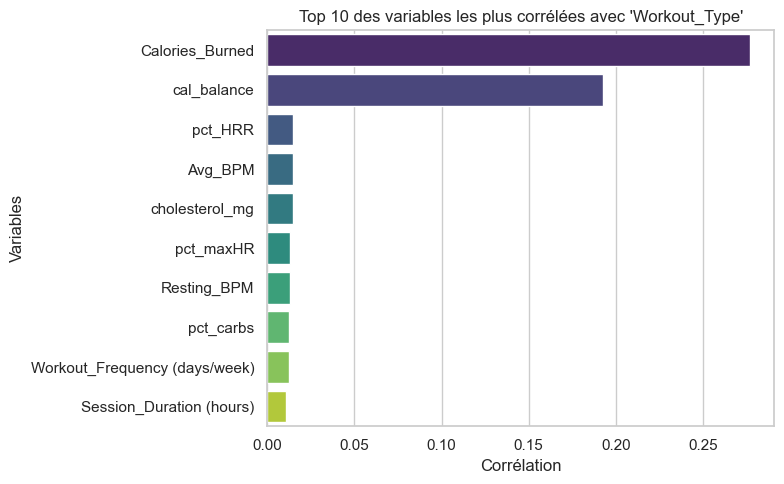

In [411]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()['Workout_Type_encode'].drop('Workout_Type_encode')

# Sélection du top 5 en valeur absolue
top10 = corr.abs().sort_values(ascending=False).head(10)
top10_names = top10.index
print(top10_names)
# On récupère les valeurs "signées" pour le graphique
top10_signed = corr[top10_names].abs()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top10_signed.values,
    y=top10_signed.index,
    palette="viridis"
)

plt.title("Top 10 des variables les plus corrélées avec 'Workout_Type'")
plt.xlabel("Corrélation")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


### Variables explicatives pour "Workout_Type"

In [402]:
features = ["Session_Duration (hours)","Calories_Burned",
    "Experience_Level","Weight (kg)"]

target = "Workout_Type_encode"
X = df[features].copy()
y = df[target]


## Séparation des données en ensemble d'entraînement et de test

Nous séparons les données en :
- un ensemble d’entraînement pour apprendre les modèles, il represente 80% du dataset,
- un ensemble de test pour évaluer leurs performances réelles, il represente 20% du dataset.

Le paramètre `stratify=y` préserve la proportion des classes dans les deux ensembles.



In [379]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


## Normalisation des données

Les modèles utilisés (KNN, SVM, régression logistique) nécessitent des données mises à la même échelle.
On utilise donc `StandardScaler` pour standardiser toutes les variables numériques.

Cela permet d’éviter que des variables à grande échelle influencent trop les modèles.


In [380]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features)
    ]
)


## Modèles supervisés

On teste différents modèles : KNN, Arbre de décision et Régression logistique.


La matrice de confusion permet de visualiser les erreurs du modèle :
- la diagonale correspond aux prédictions correctes,
- les autres cases correspondent aux confusions entre types d’entraînement.

Cela montre quelles classes sont les plus fiables et lesquelles sont les plus difficiles à distinguer.


## Graphique de la cible Workout_Type

In [382]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Arbre de Decision

=== Decision Tree ===
Scores par pli : [0.8928125 0.916875  0.8875    0.888125  0.900625 ]
Moyenne : 0.897
Écart-type : 0.011


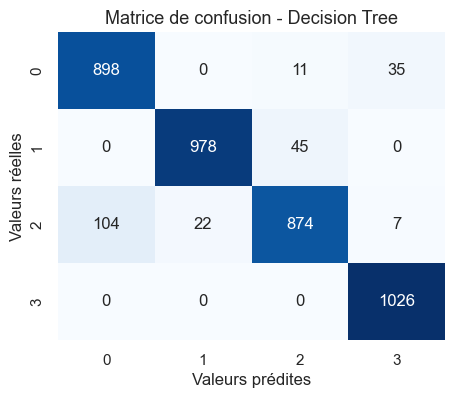

In [405]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model1 = DecisionTreeClassifier(max_depth=7, random_state=42)
scores1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='accuracy')

print("=== Decision Tree ===")
print("Scores par pli :", scores1)
print("Moyenne :", scores1.mean().round(3))
print("Écart-type :", scores1.std().round(3))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion - Decision Tree", fontsize=13)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()


### Interprétation de la matrice de confusion du modèle Decision Tree

Le modèle Decision Tree est beaucoup plus performant que le KNN, avec une accuracy proche de 90%.  


- La classe 0 est très bien reconnue : presque toutes les valeurs sont correctement prédites.
- La classe 1 est aussi très bien identifiée, même si quelques observations sont confondues avec la classe 2.
- La classe 2 est bien prédite dans l’ensemble, mais on observe quelques erreurs vers les classes 0 et 1.
- La classe 3 est parfaitement reconnue : aucune confusion avec les autres classes.

En résumé, le Decision Tree distingue très bien les quatre catégories.  
Il fait très peu d’erreurs, surtout comparé au KNN, ce qui en fait un modèle beaucoup plus adapté à ce problème.


### Interprétation des hyperparamètres
**`max_depth=6` (arbre de décision)**  
  Une profondeur trop élevée entraîne du sur-apprentissage.  
  Une profondeur trop faible entraîne un modèle trop simple.  
  `max_depth=6` est un compromis raisonnable entre complexité et généralisation.

# KNN

=== KNN ===
Scores par pli : [68.1875  68.53125 68.65625 69.34375 68.     ]
Moyenne : 68.544
Écart-type : 0.005

=== Évaluation sur le jeu de test ===
Accuracy test : 69.950


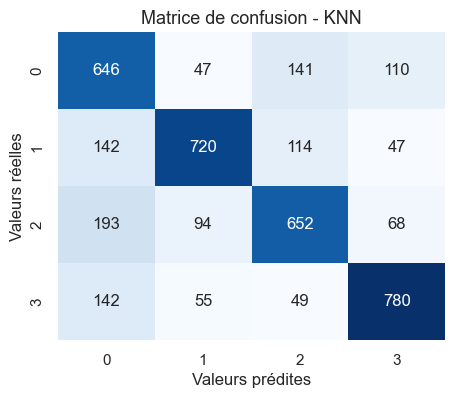

In [406]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model3 = KNeighborsClassifier(n_neighbors=3)
scores3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='accuracy')

print("=== KNN ===")
print("Scores par pli :", scores3*100)
print("Moyenne :", (scores3.mean()*100).round(3))
print("Écart-type :", scores3.std().round(3))


model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("\n=== Évaluation sur le jeu de test ===")
print(f"Accuracy test : {acc_test*100:.3f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion - KNN", fontsize=13)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

### Interprétation de la matrice de confusion du modèle KNN

Le modèle KNN a une accuracy d’environ 70%, ce qui signifie qu’il se trompe assez souvent pour ce type de prédiction.  

- La classe 0 est parfois bien reconnue, mais elle est aussi souvent prise pour les classes 2 ou 3.
- La classe 1 est la mieux reconnue, mais il y a encore beaucoup d’erreurs vers les classes 0 et 2.
- La classe 2 est celle où le modèle se trompe le plus : elle est fréquemment prédite comme 0 ou 1.
- La classe 3 est la plus facile à reconnaître, même si certaines valeurs sont encore confondues avec la classe 0.

En résumé, le KNN n’arrive pas bien à séparer les quatre classes.  
Il fait beaucoup de confusions, ce qui montre qu’il n’est pas le meilleur modèle pour ce problème.


# Regression Logistique

=== Regression Logistique ===
Scores par pli : [94.46875 93.1875  88.875   96.15625 94.71875]
Moyenne : 93.5
Écart-type : 0.025

=== Évaluation sur le jeu de test ===
Accuracy test : 0.944


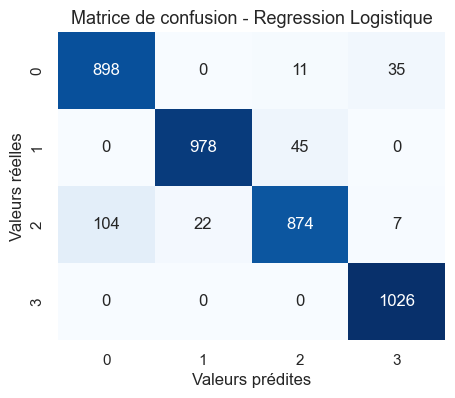

In [407]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model4 = LogisticRegression(max_iter=1000)
scores4 = cross_val_score(model4, X_train, y_train, cv=5, scoring='accuracy')

print("=== Regression Logistique ===")
print("Scores par pli :", scores4*100)
print("Moyenne :", scores4.mean().round(3)*100)
print("Écart-type :", scores4.std().round(3))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("\n=== Évaluation sur le jeu de test ===")
print(f"Accuracy test : {acc_test:.3f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matrice de confusion - Regression Logistique", fontsize=13)
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

### Interprétation de la matrice de confusion du modèle de Régression Logistique

La régression logistique donne d’excellents résultats, avec une accuracy d’environ 94%.  
- La classe 0 est presque parfaitement prédite : la grande majorité des valeurs sont justes.
- La classe 1 est aussi très bien reconnue, même si quelques observations sont confondues avec la classe 2.
- La classe 2 est globalement bien prédite, avec quelques erreurs vers les classes 0 et 1.
- La classe 3 est parfaitement reconnue, avec toutes les prédictions correctes.

En résumé, la régression logistique est très performante sur ce problème.  
Elle distingue très bien les différentes catégories et fait encore moins d’erreurs que le Decision Tree.


# Comparaison des modèles 

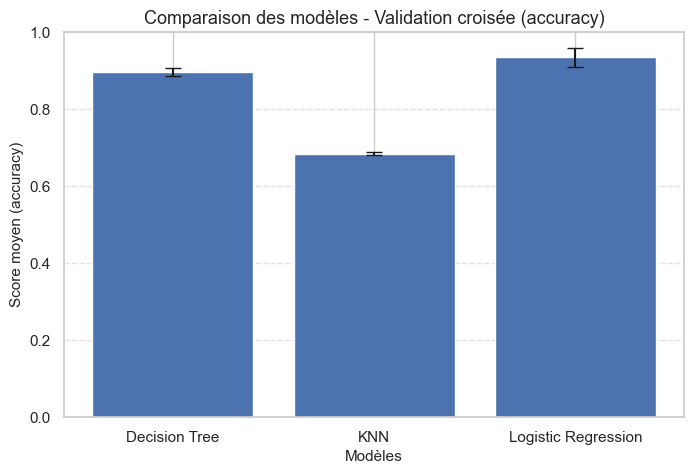

In [396]:
model_names = ["Decision Tree", "KNN", "Logistic Regression"]
mean_scores = [scores1.mean().round(3), scores3.mean().round(3), scores4.mean().round(3)] 
std_scores = [scores1.std().round(3), scores3.std().round(3), scores4.std().round(3)]   


plt.figure(figsize=(8,5))
plt.bar(model_names, mean_scores, yerr=std_scores, capsize=6)
plt.title("Comparaison des modèles - Validation croisée (accuracy)", fontsize=13)
plt.xlabel("Modèles", fontsize=11)
plt.ylabel("Score moyen (accuracy)", fontsize=11)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Interprétation des hyperparamètres

- **`max_iter=1000` (régression logistique)**  
  Ce paramètre fixe le nombre maximal d’itérations de l’algorithme d’optimisation.  
  Une valeur trop faible peut empêcher le modèle de converger.  
  Avec 1000 itérations, la convergence est garantie sans coût excessif.

- **`n_neighbors=3` (KNN)**  
  C’est le nombre de voisins utilisés pour prédire la classe.  
  Un k trop petit rend le modèle sensible au bruit, tandis qu’un k trop grand lisse trop la décision.  
  `k=3` donne ici un modèle réactif mais cela doit être validé par cross-validation.

- **`max_depth=6` (arbre de décision)**  
  Une profondeur trop élevée entraîne du sur-apprentissage.  
  Une profondeur trop faible entraîne un modèle trop simple.  
  `max_depth=6` est un compromis raisonnable entre complexité et généralisation.

L’analyse des performances permet ensuite de vérifier quel modèle est réellement le meilleur.


#### LA REGRESSION LOGISTIQUE EST LE MEILLEUR MODEL POUR CETTE PREDICTION AVEC 86,8% APRES LA CROSS-VALIDATION

## Fonction de test manuel

Cette fonction permet de simuler un individu et d’obtenir une prédiction du type d’entraînement associé.  
Elle est utile pour tester le modèle sur des cas concrets.


In [397]:
import numpy as np

def predict_workout(model, session_duration, calories_burned, experience_level, weight):
    x = np.array([session_duration, calories_burned, experience_level, weight]).reshape(1, -1)
    prediction = model.predict(x)[0]
    mapping = {1: "Cardio",2: " HIIT",3: "Strength",4: "Yoga"}

    print(f"Type d'entraînement prédit : {mapping.get(prediction, 'Inconnu')} (classe {prediction})")


In [398]:
predict_workout(model4, 2, 2000, 2, 57)

Type d'entraînement prédit : Strength (classe 3)
